# Emotion Analysis with SVM

In this notebook, we'll implement emotion analysis with SVM on the EmotionLines dataset using sklearn and nltk.

### Import Packages

In [1]:
import json

import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

### Data Preparation and Processing

In [2]:
# Read the data into `DataFrame`s:
with open("EmotionLines/Friends/friends_train.json") as f:
    train_json = json.load(f)
train_df = pd.DataFrame([item for sublist in train_json for item in sublist])

with open("EmotionLines/Friends/friends_test.json") as f:
    test_json = json.load(f)
test_df = pd.DataFrame([item for sublist in test_json for item in sublist])

In [3]:
# Define a function for processing the text:
def process_text(text):
    # Tokenize:
    tokens = word_tokenize(text)

    # Remove the stop words:
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Initialize the stemmer and lemmatizer:
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Stem the filtered tokens:
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    # Lemmatize the filtered tokens:
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return pd.Series([tokens, filtered_tokens, stemmed_tokens, lemmatized_tokens], index=["tokens", "filtered tokens", "stemmed tokens", "lemmatized tokens"])

In [4]:
# Append processed `utterance` column of `train_df` to `train_df`:
train_df = pd.concat([train_df, train_df["utterance"].apply(process_text)], axis=1)

# Append processed `utterance` column of `test_df` to `test_df`:
test_df = pd.concat([test_df, test_df["utterance"].apply(process_text)], axis=1)

In [5]:
train_df['emotion'].value_counts()

emotion
neutral        4752
non-neutral    2017
joy            1283
surprise       1220
anger           513
sadness         351
disgust         240
fear            185
Name: count, dtype: int64

In [6]:
test_df['emotion'].value_counts()

emotion
neutral        1287
non-neutral     541
joy             304
surprise        286
anger           161
sadness          85
disgust          68
fear             32
Name: count, dtype: int64

In [7]:
# Use the `utterance` column as `X` and the `emotion` column as `y`:
X_train = train_df["utterance"].values
y_train = train_df["emotion"].values

X_test = test_df["utterance"].values
y_test = test_df["emotion"].values

In [8]:
# Create a TF-IDF vectorizer:
vectorizer = TfidfVectorizer()

# Fit and transform the the training data with the TF-IDF vectorizer:
X_train = vectorizer.fit_transform(X_train)

# Transform the testing data with the TF-IDF vectorizer:
X_test= vectorizer.transform(X_test)

### SVM

In [9]:
# Choose the model with the best kernel from three types of kernels:
kernels = ["linear", "poly", "rbf", "sigmoid"]
best_kernel = ""
best_model = None
best_avg_score = -1
for kernel in kernels:
    svc_model = SVC(kernel=kernel)
    avg_score = cross_val_score(svc_model, X_train, y_train, cv=5).mean()
    if avg_score > best_avg_score:
        best_kernel = kernel
        best_model = svc_model
        best_avg_score = avg_score
print(f"Best kernel for model: {best_kernel}. Average cross validation score: {best_avg_score}.")

Best kernel for model: linear. Average cross validation score: 0.49938444728878945.


In [10]:
# Fit the training data with the best model and use it to make predictions on the testing data:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [11]:
# Evaluate the results:
print("Classification report on testing data:")
print(classification_report(y_test, y_pred))
print("Accuracy score on testing data:")
print(accuracy_score(y_test, y_pred))

Classification report on testing data:
              precision    recall  f1-score   support

       anger       0.67      0.01      0.02       161
     disgust       0.62      0.07      0.13        68
        fear       0.00      0.00      0.00        32
         joy       0.55      0.22      0.32       304
     neutral       0.52      0.92      0.67      1287
 non-neutral       0.33      0.11      0.16       541
     sadness       0.69      0.13      0.22        85
    surprise       0.61      0.33      0.43       286

    accuracy                           0.52      2764
   macro avg       0.50      0.23      0.24      2764
weighted avg       0.51      0.52      0.43      2764

Accuracy score on testing data:
0.516642547033285


/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


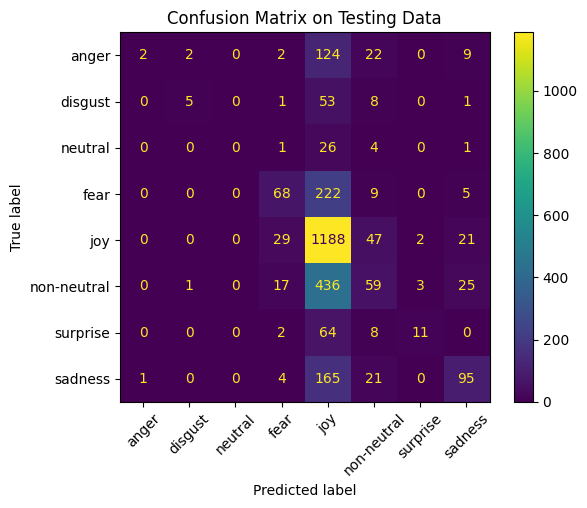

In [12]:
# Plot the confusion matrix:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["anger", "disgust", "neutral", "fear", "joy", "non-neutral", "surprise", "sadness"])
cm_display.plot()
plt.title("Confusion Matrix on Testing Data")
plt.xticks(rotation=45)
plt.show()

Now, let's try to make predictions on new custom texts:

In [13]:
text_new = "I'm really happy with our trip today! It was great!"
text_new_processed = " ".join(process_text(text_new)["lemmatized tokens"])  # Choose the `lemmatized tokens` column
text_new_processed

"'m really happy trip today ! great !"

In [14]:
X_new = vectorizer.transform([text_new_processed])
y_pred_new = best_model.predict(X_new)
print(f"Predicted emotion: {y_pred_new.item()}")

Predicted emotion: joy
